In [1]:
# Преоразовать существующий код для распознавания последовательности рукописных символов в текст.
# Написать генератор произвольной последовательности рукописных символов.

# ГЕНЕРАЦИЯ НАБОРА ДАННЫХ
# Сгенерировать набор текстовых строк из допустимых символов.
# Каждому набору поставить в соотвествие массив изоражений соответствующих символов.
# Добавить пробелы для разделения слов, символы пробелов не использовать во время классификации.

# КЛАССИФИКАЦИЯ (k ближайших соседей) (пример AIM practice 2)
# Часть символов оставить для обучения классификатора . Остальные  классифицировать
# по аналогии с примером mnist с прошлого занятия. Т.е. преобразовывать изображение в вектор.
# Выбрать оптимальный классификатор в зависимости от k- количество соседей.
# Метрика для измерения точности классификации, и выбора оптимального классификатора относительно параметра k - accuracy.

# РАСПОЗНАВАНИЕ
# заменить inf_net на последовательное применение следующих шагов:
# 1. генерация изображения с последовательностью символов
# 2. Выделение объектов оставляете как есть.
# 3. Примернить k-nn для решения задачи классификации. 
# 4. Вывести результат

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from random import shuffle, choice, randint
from collections.abc import Iterator
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns

# ГЕНЕРАЦИЯ НАБОРА ДАННЫХ

## Функция предобработки

In [3]:
def preprocess_image(img, img_size=40):
    """
    Предобработка изображения символа согласно заданному алгоритму
    """
    # Конвертируем в grayscale если нужно
    if len(img.shape) == 3:
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        img_gray = img.copy()
    
    # Применяем морфологические операции
    kernel = np.ones((3,3), np.uint8)
    img_gray = cv2.erode(img_gray, kernel, iterations=1)
    img_gray = cv2.bitwise_not(img_gray)
    
    # Добавляем padding
    base_size = (img_gray.shape[0] + 6, img_gray.shape[1] + 6)
    base = np.zeros(base_size, dtype=np.uint8)
    base[3:img_gray.shape[0] + 3, 3:img_gray.shape[1] + 3] = img_gray
    base = cv2.cvtColor(base, cv2.COLOR_GRAY2RGB)
    
    # Resize и нормализация
    base = cv2.resize(base, (img_size, img_size))
    base = base.astype(np.float32) / 255.0
    
    return base

## Датасет

In [ ]:
class CharDataset:
    """
    Датасет для загрузки и хранения изображений символов
    """
    
    def __init__(self, data_path, img_size=45, max_images_per_char=50):
        self.data_path = data_path
        self.img_size = img_size
        self.max_images_per_char = max_images_per_char
        
        # Загружаем доступные символы и заменяем 'times' на '*'
        self.name_folders = self._get_character_folders(data_path)
        self.available_chars = self._replace_times_with_asterisk(self.name_folders)
        
        # Загружаем и предобрабатываем изображения
        self.char_images = self._load_preprocess_images()

    @staticmethod
    def _get_character_folders(data_path):
        character_folders = []
        
        items = os.listdir(data_path)
        character_folders = [item for item in items]
        character_folders.sort()
        return character_folders

    @staticmethod
    def _replace_times_with_asterisk(name_folders):
        replaced_chars = []
        for char in name_folders:
            if char == 'times':
                replaced_chars.append('*')
            else:
                replaced_chars.append(char)
        return replaced_chars

    def _load_preprocess_images(self):
        char_images = {}
        
        for original_char, display_char in zip(self.name_folders, self.available_chars):
            char_path = os.path.join(self.data_path, original_char)
            images = []
            
            # Получаем список всех файлов и перемешиваем
            all_files = [f for f in os.listdir(char_path) 
                        if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
            
            # Ограничиваем количество загружаемых файлов
            files_to_load = all_files[:self.max_images_per_char]
            
            for file in files_to_load:
                img_path = os.path.join(char_path, file)
                img = cv2.imread(img_path)
                
                if img is not None:
                    if (img.shape[0] != self.img_size):
                        img = cv2.resize(img, (self.img_size, self.img_size))
                    images.append(img)
            
            # Используем display_char (с заменой 'times' на '*') как ключ
            char_images[display_char] = images
        return char_images
    
    def get_random_char_image(self, char):
        images = self.char_images.get(char, [])
        return choice(images) if images else None
    
    def get_all_data(self):
        X = []
        y = []
        
        for char_idx, char in enumerate(self.available_chars):
            for img in self.char_images[char]:
                X.append(img)
                y.append(char_idx)
        
        return np.array(X), np.array(y), self.available_chars
    
    def __len__(self):
        total = 0
        for images in self.char_images.values():
            total += len(images)
        return total
    

    # Для вывода
    def __repr__(self):
        return f"CharDataset(data_path='{self.data_path}', " \
               f"img_size={self.img_size}, chars={len(self.available_chars)}, " \
               f"total_images={len(self)}, max_per_char={self.max_images_per_char})"
    
    def print_loading_stats(self):
        """Выводит статистику по загруженным изображениям"""
        total_images = 0
        print("\nСтатистика загрузки изображений:")
        for char, images in self.char_images.items():
            print(f"  '{char}': {len(images)} изображений")
            total_images += len(images)
        print(f"Всего загружено: {total_images} изображений")
        print(f"Максимум на символ: {self.max_images_per_char}")

## Генератор последовательностей

In [5]:
class SequenceGenerator:
    def __init__(self, char_dataset, min_length=3, 
                 max_length=15, space_width_ratio=0.5):
        self.char_dataset = char_dataset
        self.min_length = min_length
        self.max_length = max_length
        self.space_width_ratio = space_width_ratio
        
        # Счетчики для итератора
        self._current_index = 0
        self._generated_count = 0
        
    def generate_random_sequence(self):
        """Генерирует случайную последовательность символов"""
        length = randint(self.min_length, self.max_length)
        sequence = []
        labels = []
        
        for _ in range(length):           
            # Добавляем случайный символ
            char = choice(self.char_dataset.available_chars)
            sequence.append(char)
            labels.append(self.char_dataset.available_chars.index(char))
        return sequence, labels
    
    def create_sequence_image(self, sequence, labels):
        """Создает изображение последовательности символов"""
        images = []
        for char, label in zip(sequence, labels):
            char_img = self.char_dataset.get_random_char_image(char)
            if char_img is not None:
                images.append(char_img)
            else:
                # Если нет изображений, создаем пустое
                print(f"Предупреждение: нет изображений для символа '{char}'")
                empty_img = np.ones((self.char_dataset.img_size, self.char_dataset.img_size, 3), dtype=np.float32)
                images.append(empty_img)
        # Объединяем все изображения в одну последовательность
        if images:
            sequence_image = np.hstack(images)
            return sequence_image
        return np.zeros((self.char_dataset.img_size, self.char_dataset.img_size, 3), dtype=np.float32)

    def __repr__(self):
        return f"SequenceGenerator(chars={len(self.char_dataset.available_chars)}, " \
               f"sequence_length={self.min_length}-{self.max_length})"

# КЛАССИФИКАЦИЯ

### Функция предобработки

### Классификатор

In [ ]:
class CharClassifier:
    def __init__(self, char_dataset):
        self.char_dataset = char_dataset
        self.model = None
        self.best_k = None
        self.accuracy_history = {}

        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.char_labels = None

    @staticmethod
    def _preprocess_image(img, img_size=40):
        # Конвертируем в grayscale если нужно
        if len(img.shape) == 3:
            img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        else:
            img_gray = img.copy()
        
        # Применяем морфологические операции
        kernel = np.ones((3,3), np.uint8)
        img_gray = cv2.erode(img_gray, kernel, iterations=1)
        img_gray = cv2.bitwise_not(img_gray)
        
        # Добавляем padding
        base_size = (img_gray.shape[0] + 6, img_gray.shape[1] + 6)
        base = np.zeros(base_size, dtype=np.uint8)
        base[3:img_gray.shape[0] + 3, 3:img_gray.shape[1] + 3] = img_gray
        base = cv2.cvtColor(base, cv2.COLOR_GRAY2RGB)
        
        # Resize и нормализация
        base = cv2.resize(base, (img_size, img_size))
        base = base.astype(np.float32) / 255.0
        
        return base

    def prepare_data(self, test_size=0.3, random_state=42):
        X, y, chars = self.char_dataset.get_all_data()
        X = [preprocess_image(x, self.char_dataset.img_size) for x in X]
        
        # Преобразуем изображения в векторы
        n_samples = len(X)
        X_flat = X.reshape((n_samples, -1))  # Преобразуем в 1D векторы

        # Разделяем на обучающую и тестовую выборки
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X_flat, y, test_size=test_size, random_state=random_state, stratify=y
        )
        self.char_labels = chars
        return self.X_train, self.X_test, self.y_train, self.y_test
    
    def find_optimal_k(self, k_range=None):
        if k_range is None:
            k_range = range(1, 10, 2)
        
        best_accuracy = 0
        best_k = 1

        for k in k_range:
            knn = KNeighborsClassifier(n_neighbors=k)
            knn.fit(self.X_train, self.y_train)
            y_pred = knn.predict(self.X_test)
            accuracy = accuracy_score(self.y_test, y_pred)
            self.accuracy_history[k] = accuracy

            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_k = k
        
        self.best_k = best_k
        return best_k, best_accuracy, self.accuracy_history
    
    def train_best_model(self):
        if self.best_k is None:
            self.find_optimal_k()

        self.model = KNeighborsClassifier(n_neighbors=self.best_k)
        self.model.fit(self.X_train, self.y_train)
        return self.model
    
    def evaluate_model(self):
        if self.model is None:
            self.train_best_model()
        
        y_pred = self.model.predict(self.X_test)
        accuracy = accuracy_score(self.y_test, y_pred)
        cm = confusion_matrix(self.y_test, y_pred)
        return accuracy, cm, y_pred
    
    def get_data_info(self):
        X, y, chars = self.char_dataset.get_all_data()
        
        info = {
            'original_distribution': np.unique(y, return_counts=True),
            'data_shape': X.shape,
            'char_labels': chars,
            'n_classes': len(chars)
        }
        if self.X_train is not None:
            info.update({
                'train_distribution': np.unique(self.y_train, return_counts=True),
                'test_distribution': np.unique(self.y_test, return_counts=True),
                'train_size': len(self.X_train),
                'test_size': len(self.X_test)
            })
        return info

    def get_error_analysis(self, y_pred):
        errors = y_pred != self.y_test
        error_indices = np.where(errors)[0]
        
        if len(error_indices) == 0:
            return {'total_errors': 0}
        
        error_pairs = []
        for idx in error_indices:
            true_label = self.y_test[idx]
            pred_label = y_pred[idx]
            error_pairs.append((true_label, pred_label))
        
        from collections import Counter
        common_errors = Counter(error_pairs).most_common(10)
        
        analysis = {
            'total_errors': len(error_indices),
            'common_errors': common_errors,
            'char_labels': self.char_labels
        }
        
        return analysis
    
    def predict_single_image(self, image):
        if self.model is None:
            raise ValueError("Модель не обучена. Сначала вызовите train_best_model()")
        
        if len(image.shape) == 3:
            image_flat = image.reshape(1, -1)
        else:
            image_flat = image.flatten().reshape(1, -1)
        
        prediction = self.model.predict(image_flat)[0]
        probability = self.model.predict_proba(image_flat)[0]
        
        predicted_char = self.char_labels[prediction]
        confidence = probability[prediction]
        
        return predicted_char, confidence, probability

### Функции вывода для классификатора

In [7]:
def print_data_preparation_info(classifier):
    """Выводит диагностическую информацию о подготовке данных"""
    info = classifier.get_data_info()
    unique_labels, counts = info['original_distribution']
    chars = info['char_labels']
    
    print("=== ДИАГНОСТИКА РАСПРЕДЕЛЕНИЯ МЕТОК ===")
    print(f"\nФорма данных: {info['data_shape']}")
    print(f"Количество классов: {info['n_classes']}")
    
    if 'train_distribution' in info:
        train_unique, train_counts = info['train_distribution']
        test_unique, test_counts = info['test_distribution']
        
        print("\nРаспределение после разделения:")
        print("Обучающая выборка:")
        for label, count in zip(train_unique, train_counts):
            print(f"  Метка {label} ('{chars[label]}'): {count} образцов")
            
        print("Тестовая выборка:")
        for label, count in zip(test_unique, test_counts):
            print(f"  Метка {label} ('{chars[label]}'): {count} образцов")
        
        print(f"\nОбучающая выборка: {info['train_size']} образцов")
        print(f"Тестовая выборка: {info['test_size']} образцов")

def print_optimal_k_search(classifier, k_range=None):
    """Выводит процесс поиска оптимального k"""
    if k_range is None:
        k_range = range(1, 16, 2)
    
    print("Поиск оптимального k...")
    print("k\tAccuracy")
    print("-" * 15)
    
    best_k, best_accuracy, accuracy_history = classifier.find_optimal_k(k_range)
    
    for k in k_range:
        print(f"{k}\t{accuracy_history[k]:.4f}")
    
    print(f"\nОптимальное k: {best_k} с точностью {best_accuracy:.4f}")
    return best_k, best_accuracy

def print_model_evaluation(classifier, detailed_analysis=False):
    """Выводит оценку модели"""
    accuracy, cm, y_pred = classifier.evaluate_model()
    
    print(f"Точность (accuracy) на тестовой выборке: {accuracy:.4f}")
    
    print("\nОтчет классификации:")
    print(classification_report(classifier.y_test, y_pred, 
                              target_names=[str(c) for c in classifier.char_labels]))
    
    if detailed_analysis:
        print_error_analysis(classifier, y_pred)
    
    return accuracy, cm, y_pred

def print_error_analysis(classifier, y_pred):
    """Выводит анализ ошибок"""
    analysis = classifier.get_error_analysis(y_pred)
    
    if analysis['total_errors'] == 0:
        print("Нет ошибок классификации!")
        return
    
    print(f"\n=== АНАЛИЗ ОШИБОК ({analysis['total_errors']} ошибок) ===")
    print("Наиболее частые ошибки:")
    
    for (true_idx, pred_idx), count in analysis['common_errors']:
        true_char = analysis['char_labels'][true_idx]
        pred_char = analysis['char_labels'][pred_idx]
        print(f"  '{true_char}' ({true_idx}) -> '{pred_char}' ({pred_idx}): {count} раз")

def plot_results(classifier):
    """Визуализирует результаты"""
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # График точности по k
    k_values = list(classifier.accuracy_history.keys())
    accuracies = list(classifier.accuracy_history.values())
    
    axes[0].plot(k_values, accuracies, 'bo-', linewidth=2, markersize=8)
    axes[0].set_xlabel('k (количество соседей)')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_title('Зависимость точности от k')
    axes[0].grid(True, alpha=0.3)
    
    # Подсветим оптимальное k
    best_idx = k_values.index(classifier.best_k)
    axes[0].plot(classifier.best_k, accuracies[best_idx], 'ro', markersize=12, 
                label=f'Оптимальное k={classifier.best_k}')
    axes[0].legend()
    
    # Confusion matrix
    if classifier.model is not None:
        y_pred = classifier.model.predict(classifier.X_test)
        cm = confusion_matrix(classifier.y_test, y_pred)
        
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                   xticklabels=classifier.char_labels,
                   yticklabels=classifier.char_labels, ax=axes[1])
        axes[1].set_xlabel('Предсказанные метки')
        axes[1].set_ylabel('Истинные метки')
        axes[1].set_title('Матрица ошибок')
    
    plt.tight_layout()
    plt.show()

def show_sample_predictions(classifier, num_samples=10):
    """Показывает примеры предсказаний"""
    if classifier.model is None:
        classifier.train_best_model()
    
    # Выбираем случайные примеры из тестовой выборки
    indices = np.random.choice(len(classifier.X_test), num_samples, replace=False)
    
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.ravel()
    
    for i, idx in enumerate(indices):
        # Восстанавливаем изображение
        img_size = int(np.sqrt(classifier.X_test[idx].shape[0] // 3))
        if img_size * img_size * 3 == classifier.X_test[idx].shape[0]:
            img = classifier.X_test[idx].reshape(img_size, img_size, 3)
        else:
            img = classifier.X_test[idx].reshape(40, 40, 3)  # fallback
        
        # Предсказываем
        true_label = classifier.char_labels[classifier.y_test[idx]]
        pred_char, confidence, _ = classifier.predict_single_image(classifier.X_test[idx])
        
        # Отображаем
        axes[i].imshow(img)
        axes[i].set_title(f'True: {true_label}\nPred: {pred_char}\nConf: {confidence:.2f}')
        axes[i].axis('off')
        
        # Подсвечиваем правильные/неправильные предсказания
        color = 'green' if true_label == pred_char else 'red'
        axes[i].spines['bottom'].set_color(color)
        axes[i].spines['top'].set_color(color) 
        axes[i].spines['right'].set_color(color)
        axes[i].spines['left'].set_color(color)
        axes[i].spines['bottom'].set_linewidth(3)
        axes[i].spines['top'].set_linewidth(3) 
        axes[i].spines['right'].set_linewidth(3)
        axes[i].spines['left'].set_linewidth(3)
    
    plt.tight_layout()
    plt.show()

### Пример использования

In [8]:
char_dataset = CharDataset('./data', img_size=40, max_images_per_char=1000)
    

print("=== ЗАГРУЗКА ИСХОДНЫХ ДАННЫХ ===")
print(f"Найдено папок: {len(char_dataset.name_folders)}")
print(f"Имена папок: {char_dataset.name_folders}")
print(f"После замены 'times' на '*': {char_dataset.available_chars}")

print(f"Создан датасет: {char_dataset}")

char_dataset.print_loading_stats()


=== ЗАГРУЗКА ИСХОДНЫХ ДАННЫХ ===
Найдено папок: 21
Имена папок: ['(', ')', '+', ',', '-', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'h', 't', 'times', 'w', 'x', 'y']
После замены 'times' на '*': ['(', ')', '+', ',', '-', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'h', 't', '*', 'w', 'x', 'y']
Создан датасет: CharDataset(data_path='./data', img_size=40, chars=21, total_images=20184, max_per_char=1000)

Статистика загрузки изображений:
  '(': 1000 изображений
  ')': 1000 изображений
  '+': 1000 изображений
  ',': 1000 изображений
  '-': 1000 изображений
  '0': 1000 изображений
  '1': 1000 изображений
  '2': 1000 изображений
  '3': 1000 изображений
  '4': 1000 изображений
  '5': 1000 изображений
  '6': 1000 изображений
  '7': 1000 изображений
  '8': 1000 изображений
  '9': 628 изображений
  'h': 1000 изображений
  't': 1000 изображений
  '*': 1000 изображений
  'w': 556 изображений
  'x': 1000 изображений
  'y': 1000 изображений
Всего загружено: 20184 изображений
Максимум н

In [9]:
# Создаем классификатор
classifier = CharClassifier(char_dataset)

# Подготавливаем данные
print("=== ПОДГОТОВКА ДАННЫХ ===")
classifier.prepare_data(test_size=0.3)
print_data_preparation_info(classifier)

=== ПОДГОТОВКА ДАННЫХ ===
=== ДИАГНОСТИКА РАСПРЕДЕЛЕНИЯ МЕТОК ===

Форма данных: (20184, 40, 40, 3)
Количество классов: 21

Распределение после разделения:
Обучающая выборка:
  Метка 0 ('('): 700 образцов
  Метка 1 (')'): 700 образцов
  Метка 2 ('+'): 700 образцов
  Метка 3 (','): 700 образцов
  Метка 4 ('-'): 700 образцов
  Метка 5 ('0'): 700 образцов
  Метка 6 ('1'): 700 образцов
  Метка 7 ('2'): 700 образцов
  Метка 8 ('3'): 700 образцов
  Метка 9 ('4'): 700 образцов
  Метка 10 ('5'): 700 образцов
  Метка 11 ('6'): 700 образцов
  Метка 12 ('7'): 700 образцов
  Метка 13 ('8'): 700 образцов
  Метка 14 ('9'): 439 образцов
  Метка 15 ('h'): 700 образцов
  Метка 16 ('t'): 700 образцов
  Метка 17 ('*'): 700 образцов
  Метка 18 ('w'): 389 образцов
  Метка 19 ('x'): 700 образцов
  Метка 20 ('y'): 700 образцов
Тестовая выборка:
  Метка 0 ('('): 300 образцов
  Метка 1 (')'): 300 образцов
  Метка 2 ('+'): 300 образцов
  Метка 3 (','): 300 образцов
  Метка 4 ('-'): 300 образцов
  Метка 5 ('0'):

In [10]:
# Находим оптимальное k
print("\n=== ПОИСК ОПТИМАЛЬНОГО k ===")
k_range = range(1, 10, 2)
best_k, best_accuracy = print_optimal_k_search(classifier, k_range)

print(f"Количество классов: {len(classifier.char_labels)}")
print(f"Размерность признаков: {classifier.X_train.shape[1]}")


=== ПОИСК ОПТИМАЛЬНОГО k ===
Поиск оптимального k...
k	Accuracy
---------------
1	0.7147
3	0.5907
5	0.5086
7	0.4757
9	0.4536

Оптимальное k: 1 с точностью 0.7147
Количество классов: 21
Размерность признаков: 4800


In [11]:
# Обучаем модель с оптимальным k
print("\n=== ОБУЧЕНИЕ МОДЕЛИ ===")
classifier.train_best_model()
print(f"Модель обучена с k={classifier.best_k}")


=== ОБУЧЕНИЕ МОДЕЛИ ===
Модель обучена с k=1



=== ОЦЕНКА МОДЕЛИ ===
Точность (accuracy) на тестовой выборке: 0.7147

Отчет классификации:
              precision    recall  f1-score   support

           (       0.55      0.97      0.70       300
           )       0.53      0.91      0.67       300
           +       0.81      0.41      0.54       300
           ,       0.32      0.84      0.46       300
           -       0.66      0.99      0.79       300
           0       0.98      0.77      0.86       300
           1       0.56      0.80      0.66       300
           2       0.81      0.60      0.69       300
           3       0.71      0.70      0.71       300
           4       0.90      0.60      0.72       300
           5       0.81      0.65      0.72       300
           6       0.90      0.60      0.72       300
           7       0.81      0.56      0.66       300
           8       0.99      0.49      0.65       300
           9       0.96      0.45      0.61       189
           h       0.97      0.92      0.9

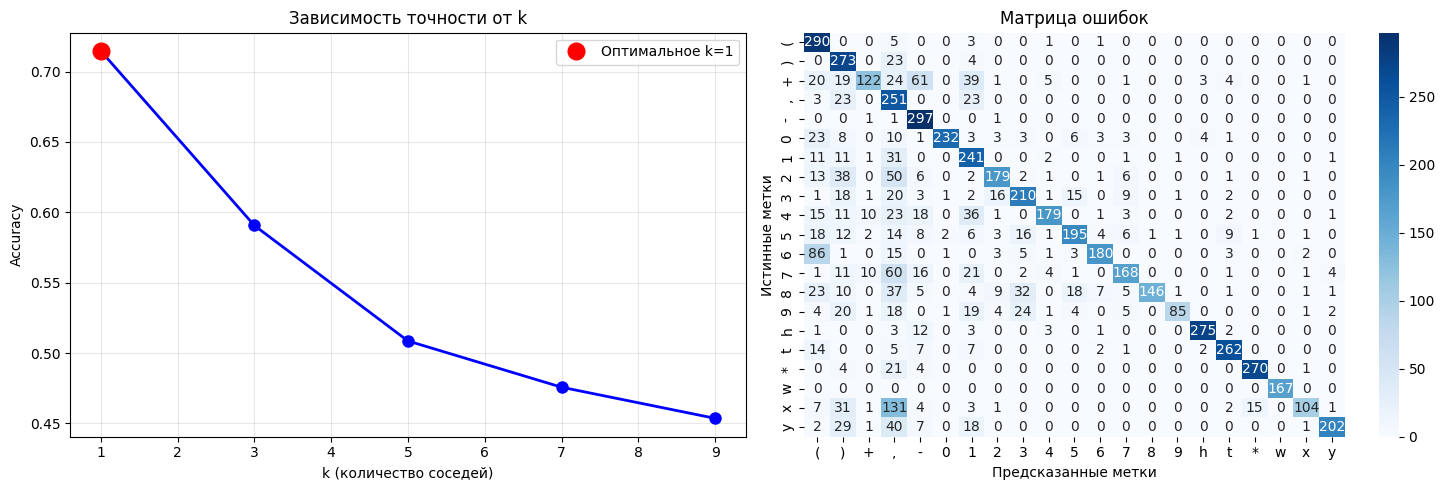


=== ПРИМЕРЫ ПРЕДСКАЗАНИЙ ===


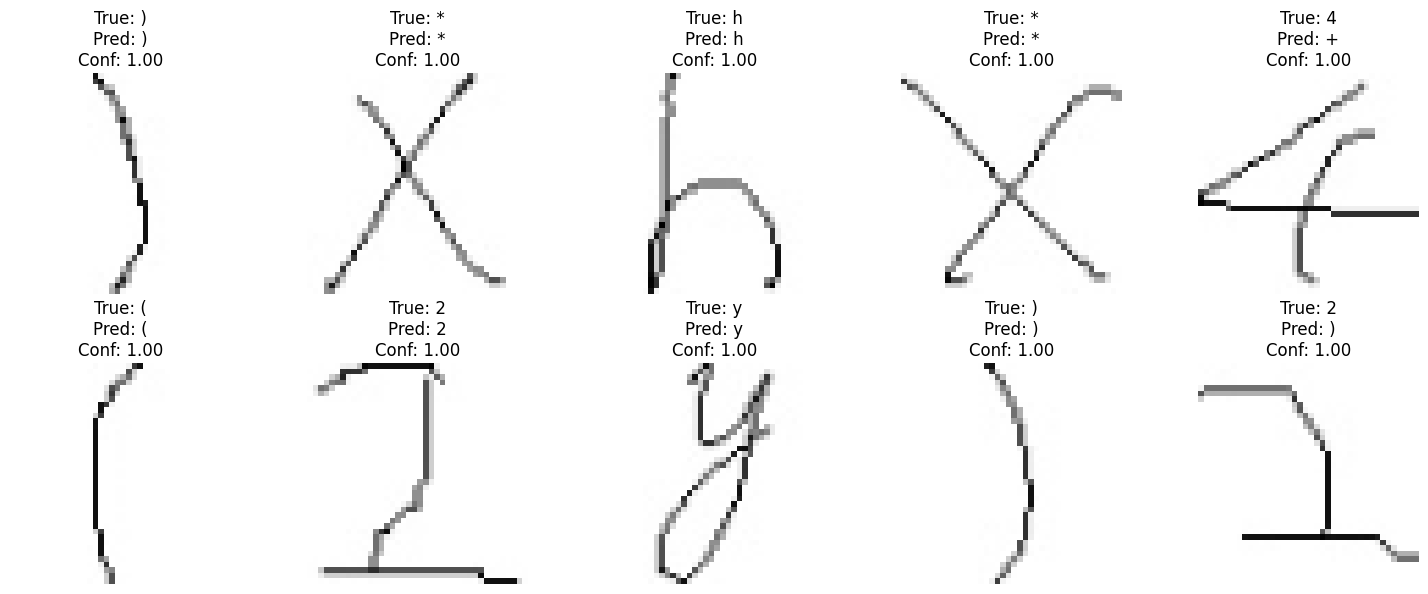

In [12]:
# Оцениваем модель
print("\n=== ОЦЕНКА МОДЕЛИ ===")
accuracy, cm, y_pred = print_model_evaluation(classifier, detailed_analysis=True)

# Визуализируем результаты
print("\n=== ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ ===")
plot_results(classifier)

# Показываем примеры предсказаний
print("\n=== ПРИМЕРЫ ПРЕДСКАЗАНИЙ ===")
show_sample_predictions(classifier, 10)

# РАСПОЗНАВАНИЕ

In [13]:

class SequenceRecognizer:
    """
    Система распознавания последовательности символов с использованием k-NN
    """
    
    def __init__(self, knn_classifier, char_dataset):
        self.knn_classifier = knn_classifier
        self.char_dataset = char_dataset
        self.char_labels = char_dataset.available_chars
        
    def preprocess_input_image(self, image_path):
        """
        Шаг 1: Предобработка входного изображения
        Аналогично оригинальному inf_net
        """
        # Загрузка изображения
        img = cv2.imread(image_path)
        
        # Конвертация в grayscale и морфологические операции
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        kernel = np.ones((3,3), np.uint8)
        img_gray = cv2.erode(img_gray, kernel, iterations=1)
        img_gray = cv2.bitwise_not(img_gray)
        
        # Добавление padding
        base_size = (img_gray.shape[0] + 6, img_gray.shape[1] + 6)
        base = np.zeros(base_size, dtype=np.uint8)
        base[3:img_gray.shape[0] + 3, 3:img_gray.shape[1] + 3] = img_gray
        base = cv2.cvtColor(base, cv2.COLOR_GRAY2RGB)
        
        img_gray = base
        
        return img, img_gray
    
    def detect_characters(self, img_rgb, img_gray):
        """
        Шаг 2: Выделение объектов (символов)
        Оставляем как в оригинальном коде
        """
        # Бинаризация
        ret, thresh = cv2.threshold(img_gray, 127, 255, 0)
        thresh = np.uint8(thresh)
        
        # Поиск контуров
        contours, h = cv2.findContours(thresh[:,:,0], cv2.RETR_EXTERNAL, 2)
        print(f"Найдено контуров: {len(contours)}")
        
        crops = []
        for i in range(len(contours)):
            cnt = contours[i]
            area = cv2.contourArea(cnt)
            x, y, w, h = cv2.boundingRect(cnt)
            
            # Фильтрация маленьких областей
            if w * h > 50:
                cv2.rectangle(img_rgb, (x, y), (x + w, y + h), (0, 0, 255), 2)
                ret, thresh_char = cv2.threshold(img_gray[y:y+h, x:x+w], 127, 255, 0)
                crops.append([x, y, w, h])
        
        print(f"Отфильтровано символов: {len(crops)}")
        return crops, img_rgb
    
    def extract_and_preprocess_chars(self, crops, img_gray):
        """
        Извлечение и предобработка отдельных символов
        Используем единую функцию предобработки
        """
        data_img = []
        
        for i in range(len(crops)):
            x, y, w, h = crops[i]
            # Корректировка координат
            x -= 3
            y -= 3
            w += 5
            h += 3
            
            # Извлечение символа
            img_char = img_gray[y:y+h, x:x+w]
            img_char = preprocess_image(img_char)
            data_img.append((x, img_char))
            
        return data_img
    
    def recognize_sequence(self, image_path, visualize=True):
        """
        Основной метод распознавания последовательности символов
        """
        print("=== ШАГ 1: ЗАГРУЗКА И ПРЕДОБРАБОТКА ИЗОБРАЖЕНИЯ ===")
        img_rgb, img_gray = self.preprocess_input_image(image_path)
        
        if visualize:
            plt.figure(figsize=(10, 5))
            plt.subplot(1, 2, 1)
            plt.imshow(img_gray)
            plt.title("Предобработанное изображение")
            plt.axis('off')
        
        print("=== ШАГ 2: ВЫДЕЛЕНИЕ СИМВОЛОВ ===")
        crops, img_with_boxes = self.detect_characters(img_rgb.copy(), img_gray)
        
        if visualize:
            plt.subplot(1, 2, 2)
            plt.imshow(img_with_boxes)
            plt.title(f"Обнаружено символов: {len(crops)}")
            plt.axis('off')
            plt.tight_layout()
            plt.show()
        
        if len(crops) == 0:
            print("Не обнаружено символов для распознавания!")
            return ""
        
        print("=== ШАГ 3: ИЗВЛЕЧЕНИЕ И ПРЕДОБРАБОТКА СИМВОЛОВ ===")
        data_img = self.extract_and_preprocess_chars(crops, img_rgb)
        
        # Визуализация извлеченных символов
        if visualize:
            n_cols = min(5, len(data_img))
            n_rows = (len(data_img) + n_cols - 1) // n_cols
            
            plt.figure(figsize=(15, 3 * n_rows))
            for i, (x, char_img) in enumerate(data_img):
                plt.subplot(n_rows, n_cols, i + 1)
                plt.imshow(char_img)
                plt.title(f"Символ {i+1}")
                plt.axis('off')
            plt.tight_layout()
            plt.show()
        
        print("=== ШАГ 4: КЛАССИФИКАЦИЯ k-NN ===")
        # Сортируем символы по x-координате (слева направо)
        sorted_chars = sorted(data_img, key=lambda item: item[0])
        predictions = []
        confidence_scores = []
        
        # Классификация каждого символа
        for i, (x, char_img) in enumerate(sorted_chars):
            # Преобразуем в вектор (как при обучении)
            char_vector = char_img.reshape(1, -1)
            
            # Предсказание с помощью k-NN
            predicted_char, confidence, probabilities = self.knn_classifier.predict_single_image(char_vector)
            
            predictions.append(predicted_char)
            confidence_scores.append(confidence)
            
            print(f"Символ {i+1}: '{predicted_char}' (уверенность: {confidence:.3f})")
        
        print("=== ШАГ 5: ФОРМИРОВАНИЕ РЕЗУЛЬТАТА ===")
        # Объединяем предсказания в строку
        result_string = ''.join(predictions)
        
        # Добавляем пробелы между словами (на основе уверенности)
        final_result = self._post_process_result(predictions, confidence_scores)
        
        print(f"\nРАСПОЗНАННАЯ ПОСЛЕДОВАТЕЛЬНОСТЬ: {final_result}")
        print(f"СЫРАЯ ПОСЛЕДОВАТЕЛЬНОСТЬ: {result_string}")
        print(f"СРЕДНЯЯ УВЕРЕННОСТЬ: {np.mean(confidence_scores):.3f}")
        
        # Визуализация результата
        if visualize:
            self._visualize_recognition_result(img_with_boxes, sorted_chars, predictions, confidence_scores)
        
        return final_result
    
    def _post_process_result(self, predictions, confidence_scores, confidence_threshold=0.7):
        """
        Пост-обработка результата для улучшения читаемости
        """
        result_parts = []
        current_word = []
        
        for i, (char, confidence) in enumerate(zip(predictions, confidence_scores)):
            # Если уверенность низкая, добавляем знак вопроса
            if confidence < confidence_threshold:
                current_word.append(f"{char}?")
            else:
                current_word.append(char)
            
            # Эвристика для добавления пробелов (если следующий символ - другой тип)
            if i < len(predictions) - 1:
                current_char_type = 'digit' if char.isdigit() else 'letter' if char.isalpha() else 'symbol'
                next_char_type = 'digit' if predictions[i+1].isdigit() else 'letter' if predictions[i+1].isalpha() else 'symbol'
                
                if current_char_type != next_char_type and confidence > confidence_threshold:
                    result_parts.append(''.join(current_word))
                    current_word = []
        
        # Добавляем последнее слово
        if current_word:
            result_parts.append(''.join(current_word))
        
        return ' '.join(result_parts)
    
    def _visualize_recognition_result(self, original_img, sorted_chars, predictions, confidence_scores):
        """
        Визуализация итогового результата распознавания
        """
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
        
        # Исходное изображение с bounding boxes
        ax1.imshow(original_img)
        ax1.set_title("Обнаруженные символы")
        ax1.axis('off')
        
        # Результат распознавания
        result_text = ''.join(predictions)
        confidence_text = f"Уверенность: {np.mean(confidence_scores):.3f}"
        
        ax2.text(0.1, 0.6, f"Распознанный текст:\n{result_text}", 
                fontsize=16, fontfamily='monospace', va='top')
        ax2.text(0.1, 0.3, confidence_text, fontsize=12, style='italic')
        
        # Добавляем информацию по каждому символу
        char_info = "\n".join([f"'{p}' ({c:.3f})" for p, c in zip(predictions, confidence_scores)])
        ax2.text(0.6, 0.6, "Символы (уверенность):\n" + char_info, 
                fontsize=10, fontfamily='monospace', va='top')
        
        ax2.set_xlim(0, 1)
        ax2.set_ylim(0, 1)
        ax2.axis('off')
        
        plt.tight_layout()
        plt.show()



# ЗАПУСК

Создан датасет: CharDataset(data_path='./data', img_size=45, chars=21, total_images=20184, max_per_char=1000)
Создан генератор: SequenceGenerator(chars=21, sequence_length=3-8)
Доступные символы: ['(', ')', '+', ',', '-', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'h', 't', '*', 'w', 'x', 'y']

--- Демонстрация генерации ---
Сгенерированная последовательность: '['(', '(', '7']'
Метки символов: [0, 0, 12]
Размер изображения последовательности: (45, 135, 3)


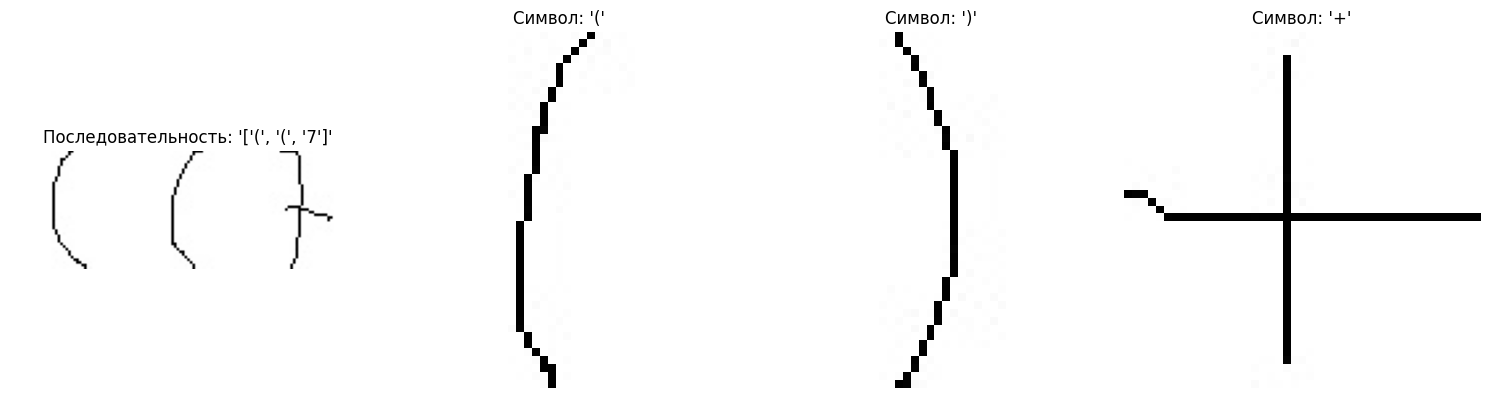

In [14]:
char_dataset = CharDataset('./data', img_size=45, max_images_per_char=1000)
    
print(f"Создан датасет: {char_dataset}")

# Создаем генератор последовательностей на основе датасета
generator = SequenceGenerator(char_dataset, min_length=3, max_length=8)

print(f"Создан генератор: {generator}")
print(f"Доступные символы: {char_dataset.available_chars}")
# Демонстрация работы
print("\n--- Демонстрация генерации ---")

# Генерация одиночной последовательности
sequence, labels = generator.generate_random_sequence()
seq_image = generator.create_sequence_image(sequence, labels)
print(f"Сгенерированная последовательность: '{sequence}'")
print(f"Метки символов: {labels}")
print(f"Размер изображения последовательности: {seq_image.shape}")

# Визуализация
plt.figure(figsize=(15, 5))

plt.subplot(1, 4, 1)
plt.imshow(seq_image)
plt.title(f"Последовательность: '{sequence}'")
plt.axis('off')

# Покажем несколько отдельных символов из датасета
for i, char in enumerate(char_dataset.available_chars[:3]):
    char_img = char_dataset.get_random_char_image(char)
    if char_img is not None:
        plt.subplot(1, 4, i + 2)
        plt.imshow(char_img)
        plt.title(f"Символ: '{char}'")
        plt.axis('off')

plt.tight_layout()
plt.show()

In [15]:
# Создаем классификатор
classifier = CharClassifier(char_dataset)

# Подготавливаем данные
print("=== ПОДГОТОВКА ДАННЫХ ===")
classifier.prepare_data(test_size=0.3)

# Находим оптимальное k
print("\n=== ПОИСК ОПТИМАЛЬНОГО k ===")

# Проверяем нечётные k от 1 до 15
k_range = range(1, 10, 2)  # 1, 3, 5, 7, 9
best_k, best_accuracy = classifier.find_optimal_k(k_range)
print(f"Количество классов: {len(classifier.char_labels)}")
print(f"Размерность признаков: {classifier.X_train.shape[1]}")

=== ПОДГОТОВКА ДАННЫХ ===

=== ПОИСК ОПТИМАЛЬНОГО k ===


ValueError: too many values to unpack (expected 2, got 3)

In [ ]:
# Обучаем модель с оптимальным k
print("\n=== ОБУЧЕНИЕ МОДЕЛИ ===")
classifier.train_best_model()

# Оцениваем модель
print("\n=== ОЦЕНКА МОДЕЛИ ===")
accuracy, cm, y_pred = classifier.evaluate_model(detailed_analysis=True)

# Визуализируем результаты
print("\n=== ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ ===")
classifier.plot_results()

# Показываем примеры предсказаний
print("\n=== ПРИМЕРЫ ПРЕДСКАЗАНИЙ ===")
classifier.show_sample_predictions(10)

# Дополнительная информация
print("\n=== ДОПОЛНИТЕЛЬНАЯ ИНФОРМАЦИЯ ===")
print(f"Оптимальный классификатор: k-NN с k={classifier.best_k}")
print(f"Точность классификации: {accuracy:.4f}")

In [ ]:
# Пример использования
def demo_recognition():
    """
    Демонстрация работы системы распознавания
    """
    # Предполагаем, что у нас уже есть обученный классификатор и датасет
    # char_dataset = CharDataset('./data', img_size=32, max_images_per_char=50)
    # classifier = CharClassifier(char_dataset)
    # classifier.prepare_data()
    # classifier.find_optimal_k()
    # classifier.train_best_model()
    
    print("=== СИСТЕМА РАСПОЗНАВАНИЯ ПОСЛЕДОВАТЕЛЬНОСТЕЙ СИМВОЛОВ ===")
    print("Используется k-NN классификатор")
    
    # Создаем распознаватель
    recognizer = SequenceRecognizer(classifier, char_dataset)
    
    # Распознаем тестовое изображение
    image_path = './test13.png'  # путь к тестовому изображению
    
    try:
        result = recognizer.recognize_sequence(image_path, visualize=True)
        
        # Дополнительная информация
        print("\n=== ИТОГОВАЯ ИНФОРМАЦИЯ ===")
        print(f"Использованный классификатор: k-NN с k={classifier.best_k}")
        print(f"Количество классов: {len(char_dataset.available_chars)}")
        print(f"Размер изображения: {char_dataset.img_size}x{char_dataset.img_size}")
        
        return result
        
    except Exception as e:
        print(f"Ошибка при распознавании: {e}")
        return ""

# Альтернатива: распознавание сгенерированной последовательности
def recognize_generated_sequence(generator, classifier, char_dataset):
    """
    Распознавание сгенерированной последовательности (для тестирования)
    """
    print("=== ТЕСТИРОВАНИЕ НА СГЕНЕРИРОВАННОЙ ПОСЛЕДОВАТЕЛЬНОСТИ ===")
    
    # Генерируем тестовую последовательность
    seq_image, sequence, labels = generator.generate_batch(1)
    test_image = seq_image[0]
    true_sequence = sequence[0]
    
    # Сохраняем сгенерированное изображение для распознавания
    test_image_path = './test_generated.png'
    # Конвертируем в uint8 для сохранения
    test_image_uint8 = (test_image * 255).astype(np.uint8)
    cv2.imwrite(test_image_path, cv2.cvtColor(test_image_uint8, cv2.COLOR_RGB2BGR))
    
    print(f"Истинная последовательность: '{true_sequence}'")
    
    # Распознаем
    recognizer = SequenceRecognizer(classifier, char_dataset)
    recognized_sequence = recognizer.recognize_sequence(test_image_path, visualize=True)
    
    # Сравниваем результаты
    accuracy = sum(1 for a, b in zip(true_sequence.replace(' ', ''), 
                                    recognized_sequence.replace(' ', '').replace('?', '')) 
                  if a == b) / max(len(true_sequence.replace(' ', '')), 1)
    
    print(f"\nСРАВНЕНИЕ:")
    print(f"Истинная:  '{true_sequence}'")
    print(f"Распознанная: '{recognized_sequence}'")
    print(f"Точность: {accuracy:.3f}")
    
    return recognized_sequence, true_sequence, accuracy

=== СИСТЕМА РАСПОЗНАВАНИЯ ПОСЛЕДОВАТЕЛЬНОСТЕЙ СИМВОЛОВ ===
Используется k-NN классификатор
=== ШАГ 1: ЗАГРУЗКА И ПРЕДОБРАБОТКА ИЗОБРАЖЕНИЯ ===
=== ШАГ 2: ВЫДЕЛЕНИЕ СИМВОЛОВ ===
Найдено контуров: 4
Отфильтровано символов: 3


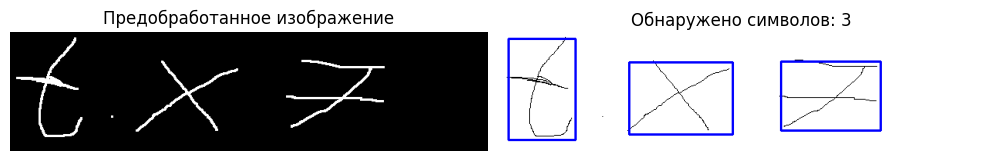

=== ШАГ 3: ИЗВЛЕЧЕНИЕ И ПРЕДОБРАБОТКА СИМВОЛОВ ===


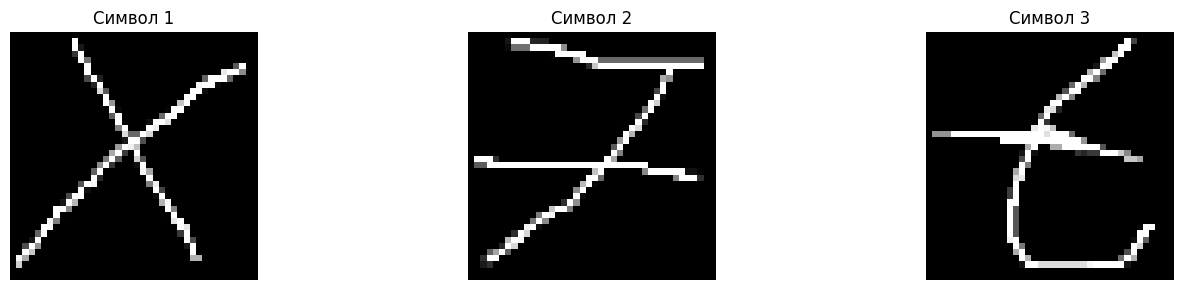

=== ШАГ 4: КЛАССИФИКАЦИЯ k-NN ===
Ошибка при распознавании: X has 4800 features, but KNeighborsClassifier is expecting 6075 features as input.
=== ТЕСТИРОВАНИЕ НА СГЕНЕРИРОВАННОЙ ПОСЛЕДОВАТЕЛЬНОСТИ ===
Истинная последовательность: '5hy1t'
=== ШАГ 1: ЗАГРУЗКА И ПРЕДОБРАБОТКА ИЗОБРАЖЕНИЯ ===
=== ШАГ 2: ВЫДЕЛЕНИЕ СИМВОЛОВ ===
Найдено контуров: 1
Отфильтровано символов: 1


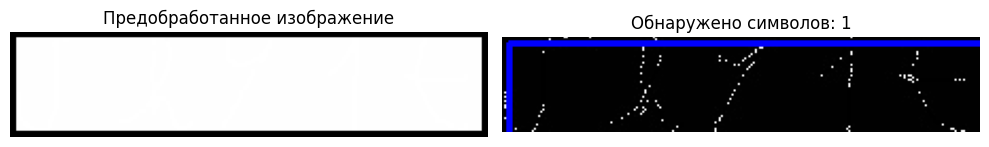

=== ШАГ 3: ИЗВЛЕЧЕНИЕ И ПРЕДОБРАБОТКА СИМВОЛОВ ===


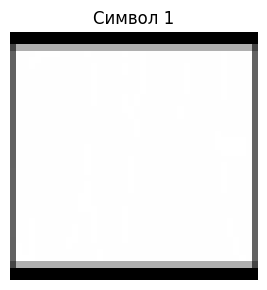

=== ШАГ 4: КЛАССИФИКАЦИЯ k-NN ===


ValueError: X has 4800 features, but KNeighborsClassifier is expecting 6075 features as input.

In [ ]:
# Демонстрация работы
demo_recognition()

# Для тестирования на сгенерированных данных раскомментируйте:
recognized, true_seq, acc = recognize_generated_sequence(generator, classifier, char_dataset)